<a href="https://colab.research.google.com/github/felixzhao/HARDataset/blob/main/Halter_V1_HAR_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib as mpl

In [2]:
import tensorflow as tf

In [3]:
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format

# load data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
root_path = "drive/MyDrive/UCI_HAR_Dataset/"

In [25]:
class HARDataSetLoader:
    def __init__(self, root_path):
        self.root = root_path
        self.file_dir = '/Inertial Signals/'
        self.file_prefix = ['total_acc_', 'body_acc_', 'body_gyro_']
        self.feature_type = ['x_', 'y_', 'z_']
        self.file_type = '.txt'

    def _get_feature_files_full_path(self, file_type:str):
        feature_files = []
        for prefix in self.file_prefix:
            for f_type in self.feature_type:
                full_path = f"{self.root}{file_type}{self.file_dir}" \
                            + f"{prefix}{f_type}{file_type}{self.file_type}"
                feature_files.append(full_path)
        return feature_files

    def _get_label_file_full_path(self, file_type:str):
        return f'{self.root}{file_type}/y_{file_type}.txt'

    def __load_file(self, file_path:str):
        return pd.read_csv(file_path, header=None, delim_whitespace=True).values

    def _load_feature(self, feature_files):
        features = np.dstack(
            [
                self.__load_file(f) for f in feature_files
            ]
        )
        return features

    def _load_label(self, label_file):
        return self.__load_file(label_file) 

    def _load(self, split_type:str):
        feature_file_names = self._get_feature_files_full_path(split_type)
        label_file_name = self._get_label_file_full_path(split_type)
        print(feature_file_names)
        print(label_file_name)
        X = self._load_feature(feature_file_names)
        y = self._load_label(label_file_name)
        print(X.shape, y.shape)
        return X, y

    def load_train(self):
        print('load train data.')
        return self._load('train')

    def load_test(self):
        print('load test data.')
        return self._load('test')
  

In [27]:
loader = HARDataSetLoader(root_path=root_path)
X_train, y_train = loader.load_train()
X_test, y_test = loader.load_test()

load train data.
['drive/MyDrive/UCI_HAR_Dataset/train/Inertial Signals/total_acc_x_train.txt', 'drive/MyDrive/UCI_HAR_Dataset/train/Inertial Signals/total_acc_y_train.txt', 'drive/MyDrive/UCI_HAR_Dataset/train/Inertial Signals/total_acc_z_train.txt', 'drive/MyDrive/UCI_HAR_Dataset/train/Inertial Signals/body_acc_x_train.txt', 'drive/MyDrive/UCI_HAR_Dataset/train/Inertial Signals/body_acc_y_train.txt', 'drive/MyDrive/UCI_HAR_Dataset/train/Inertial Signals/body_acc_z_train.txt', 'drive/MyDrive/UCI_HAR_Dataset/train/Inertial Signals/body_gyro_x_train.txt', 'drive/MyDrive/UCI_HAR_Dataset/train/Inertial Signals/body_gyro_y_train.txt', 'drive/MyDrive/UCI_HAR_Dataset/train/Inertial Signals/body_gyro_z_train.txt']
drive/MyDrive/UCI_HAR_Dataset/train/y_train.txt
(7352, 128, 9) (7352, 1)
load test data.
['drive/MyDrive/UCI_HAR_Dataset/test/Inertial Signals/total_acc_x_test.txt', 'drive/MyDrive/UCI_HAR_Dataset/test/Inertial Signals/total_acc_y_test.txt', 'drive/MyDrive/UCI_HAR_Dataset/test/Inert

# legacy load code

In [ ]:
# # load dataset
# from numpy import dstack
# from pandas import read_csv
 
# # load a single file as a numpy array
# def load_file(filepath):
#   dataframe = read_csv(filepath, header=None, delim_whitespace=True)
#   return dataframe.values
 
# # load a list of files, such as x, y, z data for a given variable
# def load_group(filenames, prefix=''):
#   loaded = list()
#   for name in filenames:
#     data = load_file(prefix + name)
#     loaded.append(data)
#   # stack group so that features are the 3rd dimension
#   loaded = dstack(loaded)
#   return loaded
 
# # load a dataset group, such as train or test
# def load_dataset(group, prefix=''):
#   filepath = prefix + group + '/Inertial Signals/'
#   # load all 9 files as a single array
#   filenames = list()
#   # total acceleration
#   filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
#   # body acceleration
#   filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
#   # body gyroscope
#   filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
#   # load input data
#   X = load_group(filenames, filepath)
#   # load class output
#   y = load_file(prefix + group + '/y_'+group+'.txt')
#   return X, y
 
# # load all train
# trainX, trainy = load_dataset('train', prefix_path)
# print(trainX.shape, trainy.shape)
# # load all test
# testX, testy = load_dataset('test', prefix_path)
# print(testX.shape, testy.shape)

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)


# train model

In [28]:
train_shape = X_train.shape
batch_size = train_shape[0]
sequence_length = train_shape[1]
number_of_features = train_shape[2]
print(f"{batch_size=}, {sequence_length=}, {number_of_features=} ")

batch_size=7352, sequence_length=128, number_of_features=9 


In [29]:
number_of_classes = len(np.unique(y_train))
num_classes = number_of_classes
print(f"{number_of_classes=}")

number_of_classes=6


In [31]:
t_y_train = y_train - 1 #trainy.flatten()
t_y_test = y_test - 1 #testy.flatten()
print(t_y_train)
print(t_y_test)

[[4]
 [4]
 [4]
 ...
 [1]
 [1]
 [1]]
[[4]
 [4]
 [4]
 ...
 [1]
 [1]
 [1]]


In [32]:
np.unique(t_y_train)

array([0, 1, 2, 3, 4, 5])

In [33]:
y_train = tf.keras.utils.to_categorical(t_y_train)
y_test = tf.keras.utils.to_categorical(t_y_test)

In [34]:
y_train[0]

array([0., 0., 0., 0., 1., 0.], dtype=float32)

In [35]:
y_test[0]

array([0., 0., 0., 0., 1., 0.], dtype=float32)

In [36]:
type(y_train)
print(len(y_train), len(y_train[0]))
y_train[0]

7352 6


array([0., 0., 0., 0., 1., 0.], dtype=float32)

In [37]:
learning_rate = 0.01
n_hidden = 32
batch_size = 64
shuffle_buffer_size = 1000
epochs = 30

In [38]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(32, input_shape=(sequence_length, number_of_features)),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(number_of_classes, activation="softmax")
])

# model.build()

#Print the model summary 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                5376      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 6)                 198       
                                                                 
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________


In [39]:
model.compile(
    loss='categorical_crossentropy', 
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
    metrics=['accuracy']
    )

In [41]:
# Train the model
# history = model.fit(trainX, trainy, validation_data=(testX, testy) ,epochs=10)
history = model.fit(X_train, y_train ,epochs=30)

Epoch 1/30
230/230 [==============================] - 12s 42ms/step - loss: 0.9649 - accuracy: 0.5928
Epoch 2/30
230/230 [==============================] - 10s 41ms/step - loss: 0.5059 - accuracy: 0.7903
Epoch 3/30
230/230 [==============================] - 10s 42ms/step - loss: 0.3924 - accuracy: 0.8667
Epoch 4/30
230/230 [==============================] - 10s 42ms/step - loss: 0.3935 - accuracy: 0.8719
Epoch 5/30
230/230 [==============================] - 10s 45ms/step - loss: 0.2187 - accuracy: 0.9290
Epoch 6/30
230/230 [==============================] - 10s 42ms/step - loss: 0.1801 - accuracy: 0.9366
Epoch 7/30
230/230 [==============================] - 10s 42ms/step - loss: 0.1885 - accuracy: 0.9346
Epoch 8/30
230/230 [==============================] - 10s 42ms/step - loss: 0.1602 - accuracy: 0.9411
Epoch 9/30
230/230 [==============================] - 10s 42ms/step - loss: 0.2624 - accuracy: 0.9057
Epoch 10/30
230/230 [==============================] - 10s 42ms/step - loss: 0.198

In [42]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    # plt.show()

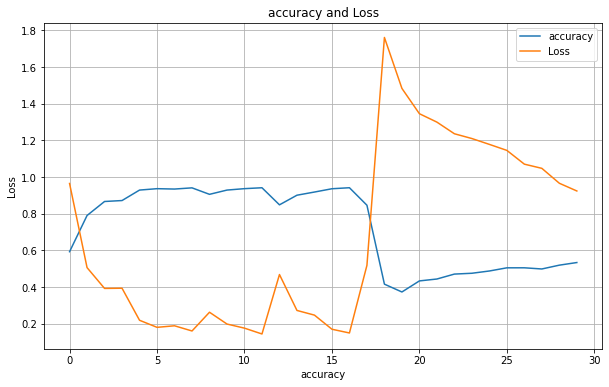

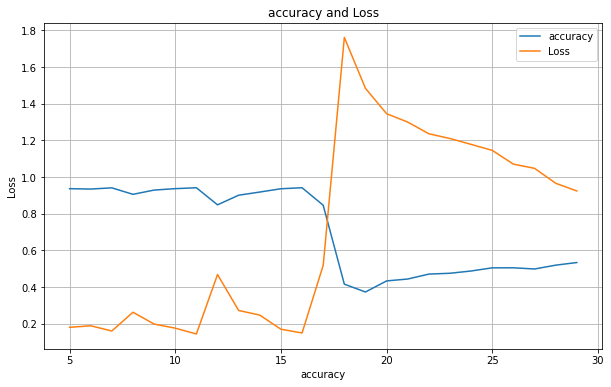

In [43]:
# Get mae and loss from history log
mae=history.history['accuracy']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss)) 

# Plot mae and loss
plot_series(
    x=epochs, 
    y=(mae, loss), 
    title='accuracy and Loss', 
    xlabel='accuracy',
    ylabel='Loss',
    legend=['accuracy', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom, 
    y=(mae_zoom, loss_zoom), 
    title='accuracy and Loss', 
    xlabel='accuracy',
    ylabel='Loss',
    legend=['accuracy', 'Loss']
    )

# evaluation model

In [45]:
score = model.evaluate(X_test, y_test)
score

93/93 [==============================] - 2s 12ms/step - loss: 0.8137 - accuracy: 0.6220


[0.8137130737304688, 0.6219884753227234]

In [46]:
y_pred = model.predict(X_test)

93/93 [==============================] - 4s 22ms/step


In [47]:
y_pred_res = tf.argmax(y_pred, axis=1)
y_test_res = tf.argmax(y_test, axis=1)

In [48]:
cm = tf.math.confusion_matrix(y_test_res, y_pred_res, num_classes=num_classes)

In [49]:
class_names = [ 'WALKING',
    'WALKING_UPSTAIRS',
     'WALKING_DOWNSTAIRS',
     'SITTING',
     'STANDING',
     'LAYING',
]

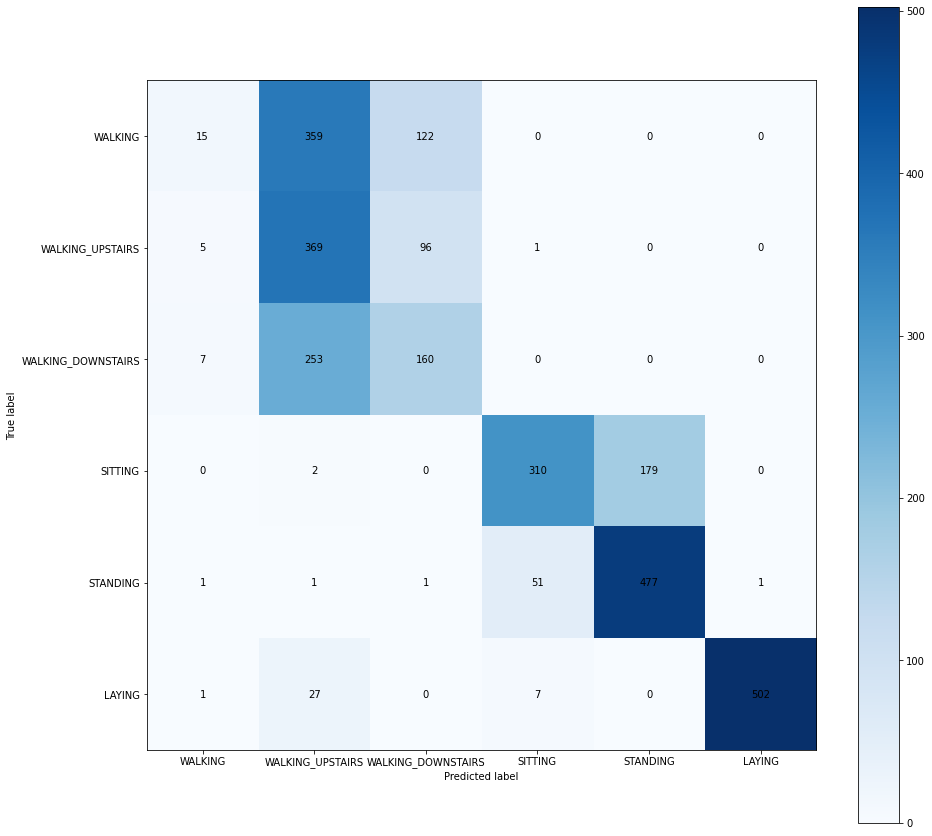

In [50]:
cm = np.array(cm)

fig, ax = plt.subplots(figsize=(15,15))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=class_names, yticklabels=class_names,
       ylabel='True label',
       xlabel='Predicted label')

# Loop over data dimensions and create text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center", color="black")

## CNN + LSTM

In [51]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(32, input_shape=(sequence_length, number_of_features)),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(64, activation="relu"),
  tf.keras.layers.Dense(number_of_classes, activation="softmax")
])

model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 128, 32)           1184      
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 6)                 390       
                                                                 
Total params: 12,006
Trainable params: 12,006
Non-trainable params: 0
_________________________________________________________________


In [53]:
model.compile(
    loss='categorical_crossentropy', 
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
    metrics=['accuracy']
    )

history = model.fit(X_train, y_train ,epochs=30)

Epoch 1/30
230/230 [==============================] - 16s 56ms/step - loss: 0.7394 - accuracy: 0.6721
Epoch 2/30
230/230 [==============================] - 17s 72ms/step - loss: 0.4052 - accuracy: 0.8474
Epoch 3/30
230/230 [==============================] - 13s 55ms/step - loss: 0.2520 - accuracy: 0.9155
Epoch 4/30
230/230 [==============================] - 13s 56ms/step - loss: 0.2384 - accuracy: 0.9142
Epoch 5/30
230/230 [==============================] - 13s 55ms/step - loss: 0.1833 - accuracy: 0.9309
Epoch 6/30
230/230 [==============================] - 13s 55ms/step - loss: 0.2275 - accuracy: 0.9192
Epoch 7/30
230/230 [==============================] - 14s 60ms/step - loss: 0.1530 - accuracy: 0.9400
Epoch 8/30
230/230 [==============================] - 13s 56ms/step - loss: 0.1538 - accuracy: 0.9436
Epoch 9/30
230/230 [==============================] - 13s 55ms/step - loss: 0.1834 - accuracy: 0.9324
Epoch 10/30
230/230 [==============================] - 13s 56ms/step - loss: 0.196

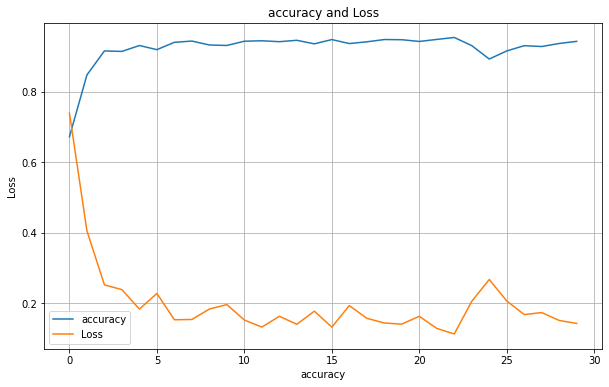

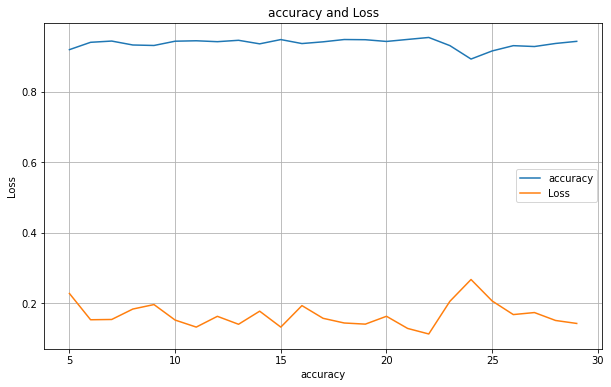

In [54]:
# Get mae and loss from history log
mae=history.history['accuracy']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss)) 

# Plot mae and loss
plot_series(
    x=epochs, 
    y=(mae, loss), 
    title='accuracy and Loss', 
    xlabel='accuracy',
    ylabel='Loss',
    legend=['accuracy', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom, 
    y=(mae_zoom, loss_zoom), 
    title='accuracy and Loss', 
    xlabel='accuracy',
    ylabel='Loss',
    legend=['accuracy', 'Loss']
    )

In [55]:
score = model.evaluate(X_test, y_test)
score

93/93 [==============================] - 2s 15ms/step - loss: 0.4770 - accuracy: 0.9097


[0.4770335853099823, 0.9097387194633484]

In [56]:
y_pred = model.predict(X_test)
y_pred_res = tf.argmax(y_pred, axis=1)

93/93 [==============================] - 2s 15ms/step


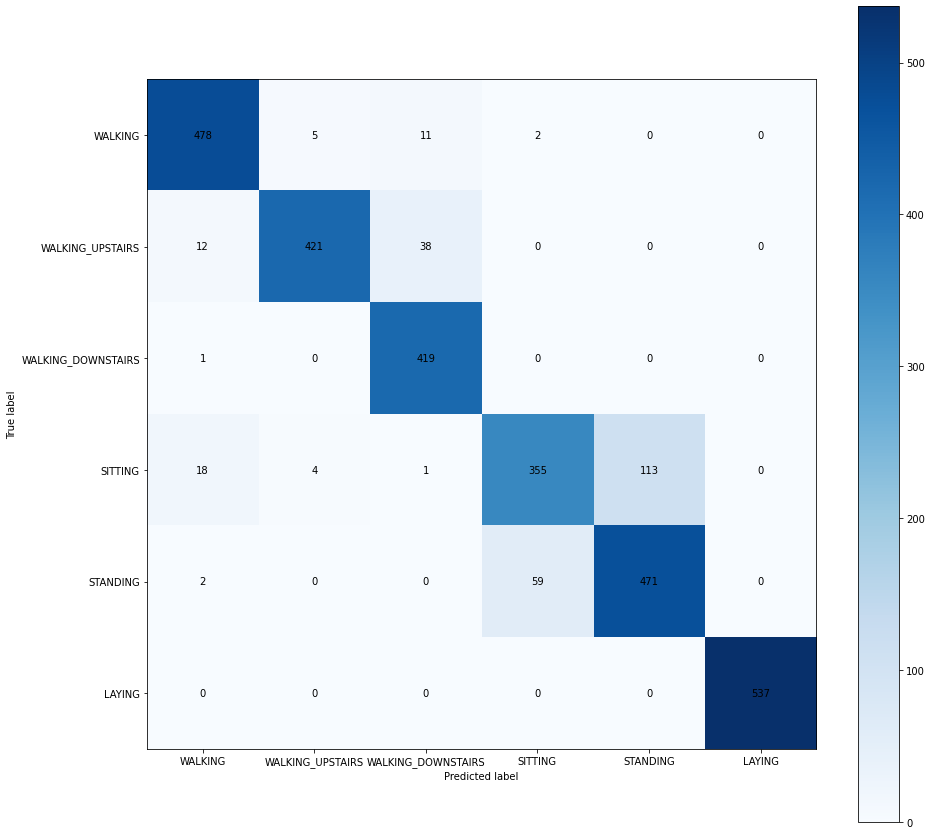

In [57]:
cm = tf.math.confusion_matrix(y_test_res, y_pred_res, num_classes=num_classes)
cm = np.array(cm)

fig, ax = plt.subplots(figsize=(15,15))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=class_names, yticklabels=class_names,
       ylabel='True label',
       xlabel='Predicted label')

# Loop over data dimensions and create text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center", color="black")

# GridSearchCV

We can use Grid Search CV to tuning the parameters of model. for example, tunning the regulariztion rate or dropout rate.


It takes too long to run thus here is the sample code, 

In [63]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from datetime import datetime

In [59]:
def create_model(l2_rate=0.0):
    model = tf.keras.models.Sequential([
      tf.keras.layers.Conv1D(filters=32, kernel_size=4,
                          strides=1,
                          activation="relu",
                          padding='causal',
                          input_shape=(sequence_length, number_of_features)),
      tf.keras.layers.LSTM(32),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(l2_rate)),
      tf.keras.layers.Dense(number_of_classes, activation="softmax")
    ])
    model.compile(
    loss='categorical_crossentropy', 
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
    metrics=['accuracy']
    )
    return model

# create the model
model = KerasClassifier(build_fn=create_model, epochs=20, batch_size=32, verbose=0)

<ipython-input-59-86912c2ff979>:21: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=20, batch_size=32, verbose=0)


In [60]:
# define the grid search parameters
l2_rate = [0.0, 0.1]#[0.0, 0.001, 0.01, 0.1]
param_grid = dict(l2_rate=l2_rate)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)

In [64]:
start_time = datetime.now()

In [ ]:
grid_result = grid.fit(X_train, y_train)

In [65]:
print(f'time cost: {datetime.now()-start_time}')

time cost: 0:00:07.428429


In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))